# devlog 2023-10-05

_author: Tyler Coles_

Now that we've added IPM support for exogenous inputs, let's re-do the problem from devlog 2023-09-29. (This time without having to do tricky workarounds.)

In [10]:
from sympy import Max

from epymorph.data_shape import Shapes
from epymorph.ipm.attribute import param
from epymorph.ipm.compartment_ipm import CompartmentModelIpmBuilder
from epymorph.ipm.compartment_model import (
    BIRTH,
    DEATH,
    compartment,
    create_model,
    create_symbols,
    edge,
)
from epymorph.ipm.ipm import IpmBuilder


def construct_ipm() -> IpmBuilder:
    symbols = create_symbols(
        compartments=[
            compartment("S"),
            compartment("I"),
            compartment("R"),
        ],
        attributes=[
            param("beta", shape=Shapes.TxN),
            param("gamma", shape=Shapes.TxN),
            param("xi", shape=Shapes.TxN),
            param("birth_rate", shape=Shapes.TxN),  # birth rate per day per capita
            param("death_rate", shape=Shapes.TxN),  # death rate per day per capita
        ],
    )

    [S, I, R] = symbols.compartment_symbols
    [β, γ, ξ, br, dr] = symbols.attribute_symbols

    N = Max(1, S + I + R)  # formulate N so as to avoid dividing by zero

    model = create_model(
        symbols=symbols,
        transitions=[
            # traditional formulation for S,I,R
            edge(S, I, rate=β * S * I / N),
            edge(I, R, rate=γ * I),
            edge(R, S, rate=ξ * R),
            # newborn individuals enter S
            edge(BIRTH, S, rate=br * (S + I + R)),
            # individuals from S,I,R die; all cause mortality
            edge(S, DEATH, rate=dr * S),
            edge(I, DEATH, rate=dr * I),
            edge(R, DEATH, rate=dr * R),
        ],
    )

    return CompartmentModelIpmBuilder(model)

In [11]:
from datetime import date
from functools import partial

import numpy as np

from epymorph.data import geo_library, mm_library
from epymorph.initializer import single_location
from epymorph.simulation import Simulation, with_fancy_messaging

# We'll use the 50+2 US States GEO and a simple centroids-based movement model.
sim = with_fancy_messaging(
    Simulation(
        ipm_builder=construct_ipm(),
        geo=geo_library["us_states_2015"](),
        mvm_builder=mm_library["centroids"](),
    )
)

out = sim.run(
    param={
        "phi": 40.0,
        "beta": 0.4,
        "gamma": 1 / 4,
        "xi": 1 / 90,
        "birth_rate": 12.314
        / 1000
        / 365,  # 12.314 persons per thousand, as an approx. daily rate
        "death_rate": 8.369
        / 1000
        / 365,  # 8.369 persons per thousand, as an approx. daily rate
    },
    start_date=date(2015, 1, 1),
    duration_days=365,
    initializer=partial(single_location, location=0, seed_size=10_000),
    rng=np.random.default_rng(1),
)

Running simulation (BasicEngine):
• 2015-01-01 to 2016-01-01 (365 days)
• 52 geo nodes
|####################| 100% 
Runtime: 8.099s


And it runs faster too! Isn't that great?

## Results

Post-processing the results is simpler since there's no "artificials" to worry about subtracting off. The only way to get at the birth and death data is through the event counts (incidence) though.

In [12]:
# How many births happened in each state on the first timestep?
display(out.incidence[0, :, 3])

array([ 52,  11,  83,  25, 433,  55,  51,   9,   7, 224,  97,  18,  15,
       154,  78,  38,  34,  49,  60,  11,  78,  77, 109,  65,  25,  82,
         9,  15,  41,  17, 107,  24, 213, 119,  12, 137,  43,  48, 142,
         8,  69,  11,  64, 302,  28,  14,  94,  79,  22,  67,   7,  38])

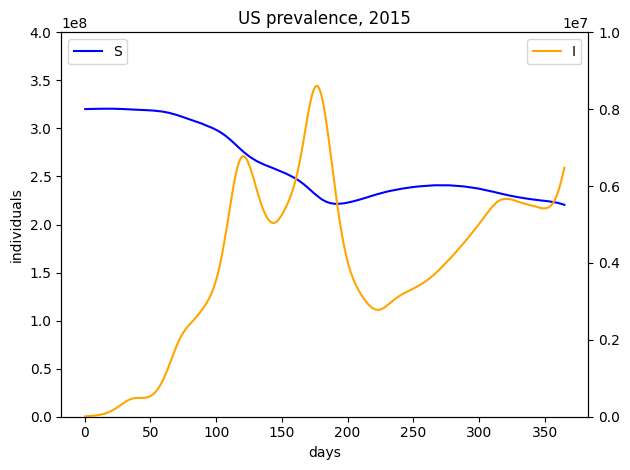

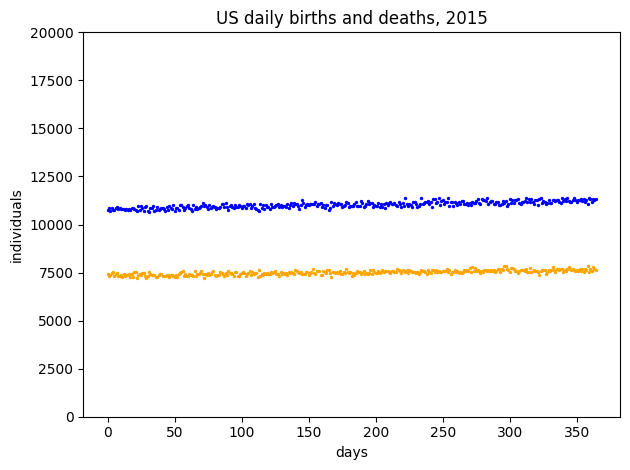

In [13]:
import matplotlib.pyplot as plt

from epymorph.util import stridesum

# Plot global S and I
fig, ax = plt.subplots()
ax2 = ax.twinx()

x_axis = [t.tausum for t in out.ctx.clock.ticks]
line1 = ax.plot(x_axis, out.prevalence[:, :, 0].sum(axis=1), label="S", color="blue")
line2 = ax2.plot(x_axis, out.prevalence[:, :, 1].sum(axis=1), label="I", color="orange")

ax.set_ylim(bottom=0, top=4e8)
ax2.set_ylim(bottom=0, top=1e7)
ax.set_title("US prevalence, 2015")
ax.set_xlabel("days")
ax.set_ylabel("individuals")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()


# Plot births and deaths
fig, ax = plt.subplots()

x_axis = np.arange(out.ctx.clock.num_days)
ax.scatter(
    x_axis,
    stridesum(out.incidence[:, :, 3].sum(axis=1), 2),
    s=2,
    label="births",
    color="blue",
)
ax.scatter(
    x_axis,
    stridesum(out.incidence[:, :, 4:7].sum(axis=(1, 2)), 2),
    s=2,
    label="deaths",
    color="orange",
)

ax.set_title("US daily births and deaths, 2015")
ax.set_xlabel("days")
ax.set_ylabel("individuals")
ax.set_ylim(bottom=0, top=2e4)

fig.tight_layout()
plt.show()